## Parameter Revovery Analysis

### TrialType (No Neutral Trials)


This parameter recovery analysis is to examine the consistency of our model simulation and maxLL pipline. 


**Details**:

 - re-run 1 round of simulation for both MODEL1(Dec) and MODEL2 (Procedural) with best fit parameter (from original maxLL output)

 - re-run maxLL pipline 
 

> NOTE: new maxLL is not exactly the same as old one. In original maxLL, data are aggregated on `TrialType` only, and `Neutral` trials are excluded. In current version, we do both: the same as old version, as well as aggregating data on `TrialType` and `BlockType`, including `Neutral Trials`


In [1]:
import sys
import os
SCRIPT_PATH = os.path.join(os.path.abspath(os.path.dirname('../__file__')), 'script')
sys.path.insert(0, SCRIPT_PATH)
from simulate import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

main_dir = os.path.abspath(os.path.dirname(os.getcwd()))
log_dir = 'data/simulation_1condition_exclude_neutral/simulation_pr_best'
main_dir, log_dir

ACT-R connection has been started.


('/home/chery/Documents/Github/RLvIBL-Re',
 'data/simulation_1condition_exclude_neutral/simulation_pr_best')

## Best Fit Parameter

Run only ONE round with best-fit parameter set for both models 


In [2]:
df1 = merge_parameter_recovery_data(main_dir=main_dir, log_dir=log_dir, model='model1')
df2 = merge_parameter_recovery_data(main_dir=main_dir, log_dir=log_dir, model='model2')

df1.shape, df2.shape

((1791, 4), (1809, 4))

In [3]:
df_recov_best = pd.concat([df1, df2], axis=0, ignore_index=True)

# eclude :lf and :r
df_recov_best = df_recov_best[df_recov_best.apply(lambda x:(x['param_name']!='lf') and (x['param_name']!='r'), axis=1)]

In [4]:
print('Unique HCPID: [%d]' % (len(df_recov_best['HCPID'].unique())))

Unique HCPID: [199]


#### Parameter Recovery

Compare original best-fit parameter and recovered best-fit parameter after feeding in maxLL pipline

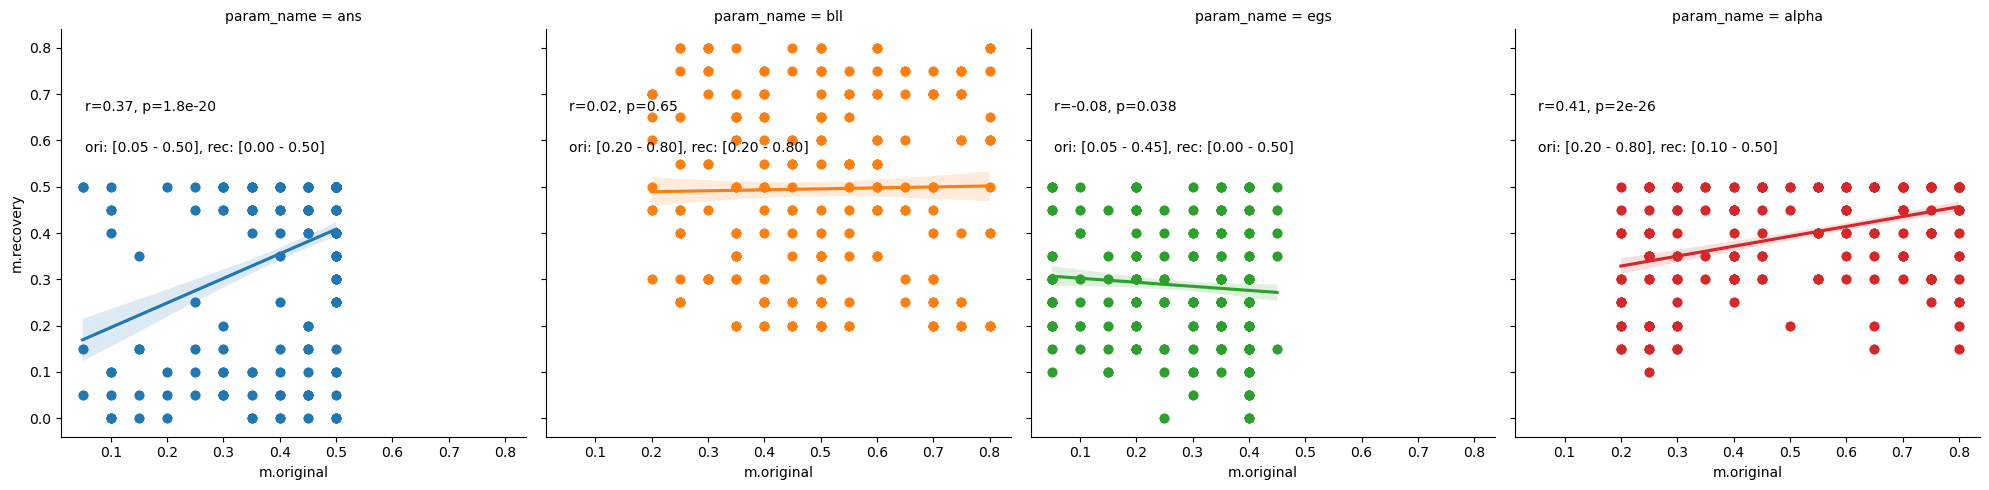

In [5]:
def annotate(data, **kws):
    r, p = stats.pearsonr(data['m.original'], data['m.recovery'])
    ax = plt.gca()
    ax.text(.05, 0.8, 'r={:.2f}, p={:.2g}'.format(r, p), 
            transform=ax.transAxes)
    min1, min2, max1, max2 = data['m.original'].min(), data['m.recovery'].min(), data['m.original'].max(), data['m.recovery'].max()
    ax.text(.05, 0.7, 'ori: [%.2f - %.2f], rec: [%.2f - %.2f]' % (min1, max1, min2, max2), 
            transform=ax.transAxes)

g = sns.lmplot(data=df_recov_best, x='m.original', y='m.recovery', hue='param_name', col='param_name')
g.map_dataframe(annotate)
plt.show()

#### Model Recovery

Compare original model classification and recovered model classification

In [10]:
# df = save_model_classification(main_dir=main_dir, subject_dir=log_dir)

In [11]:
df0 = pd.read_csv(os.path.join(main_dir, 'data/old_actr_maxLL.csv'))
df1 = pd.read_csv(os.path.join(main_dir, log_dir, 'actr_maxLL.csv'), usecols=['HCPID', 'best_model', 'LL.m1', 'LL.m2', 'LL.diff']).drop_duplicates()

# compare old vs. new
df = pd.merge(df0, df1, on='HCPID', suffixes=('.original', '.recovered'))
df['best_model.same'] = df.apply(lambda x:1 if x['best_model.original']==x['best_model.recovered'] else 0, axis=1)
print('Unique HCPID: [%d], [%d]'% (len(df0.HCPID.unique()), len(df1.HCPID.unique())))

Unique HCPID: [199], [199]


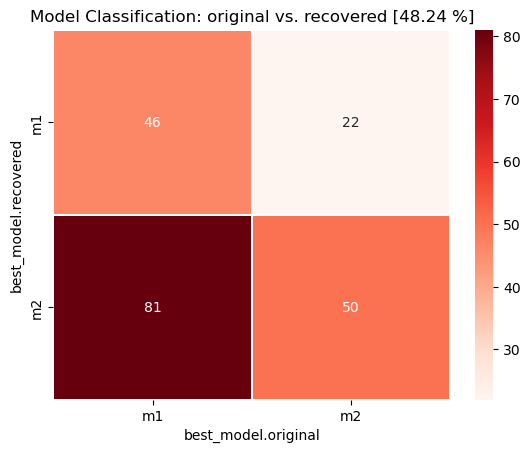

In [12]:
dfc = confusion_matrix(df, 'best_model.recovered',  'best_model.original')
ax = sns.heatmap(dfc, annot=True, fmt='d', linewidth=.2, cmap='Reds')
plt.title('Model Classification: original vs. recovered [%.2f %%]' % (100*df['best_model.same'].mean()))
plt.show()